# **Mount, import, and load data frame**

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.linear_model import LinearRegression
# import standard scaler
from sklearn.preprocessing import StandardScaler
# import knn regressor & classifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
# For model validation
from sklearn.model_selection import train_test_split
# import bagged trees & random forest
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
# linear regression feature importance
from sklearn.datasets import make_regression

In [60]:
filename = '/content/drive/MyDrive/Colab Notebooks/class_data_science/PandasForDataManipulation/sales_predictions.csv'
df = pd.read_csv(filename)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# **EDA**
Detect errors, outliers, relationships, important factors, patterns, insights

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [62]:
df.shape

(8523, 12)

In [65]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [63]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Some spelling errors need to be fixed on the Item Fat Content.

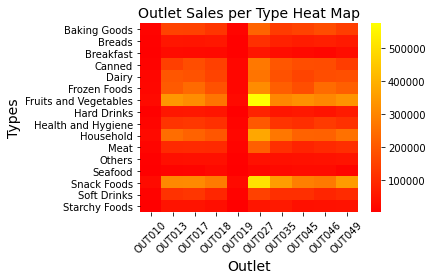

In [66]:
sales_per_outlet = df.groupby(['Outlet_Identifier', 'Item_Type'])[['Item_Outlet_Sales']].sum()
#sales_per_outlet
heatmap_data = pd.pivot_table(sales_per_outlet, values='Item_Outlet_Sales', index=['Item_Type'], columns='Outlet_Identifier')
sns.heatmap(heatmap_data, cmap='autumn');
plt.xlabel("Outlet", size=14)
plt.ylabel("Types", size=14)
plt.title("Outlet Sales per Type Heat Map", size=14)
plt.xticks(rotation = 45);
plt.tight_layout()

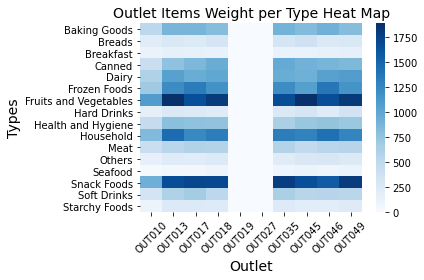

In [67]:
weight_per_outlet = df.groupby(['Outlet_Identifier', 'Item_Type'])[['Item_Weight']].sum()

heatmap_data_wieght = pd.pivot_table(weight_per_outlet, values='Item_Weight', index=['Item_Type'], columns='Outlet_Identifier')

sns.heatmap(heatmap_data_wieght, cmap='Blues');
plt.xlabel("Outlet", size=14)
plt.ylabel("Types", size=14)
plt.title("Outlet Items Weight per Type Heat Map", size=14)
plt.xticks(rotation = 45);
plt.tight_layout()

# **Cleaning**

There are some spelling errors withtin the Item_Fat_Content, we will take care of that here


In [68]:
df['Item_Fat_Content'].replace('LF','Low Fat',inplace=True)
df['Item_Fat_Content'].replace('low fat','Low Fat',inplace=True)
df['Item_Fat_Content'].replace('reg','Regular',inplace=True)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [69]:
#Figuring out how many missing values in the dataset:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Out of 8523 records there are 1463 items with missing "Item_Weight"; this will affect the analysis of the sales prediction data. I can try and find the exame same items in different rows and find out if the "Item_Weight" field was filled in and hence fill in the missing ones.
Another 2410 records are missing the Outlet_Size.

**Handeling the missing Item Weights first**

In [70]:
#The following method will find the Item_Weight from it's Item_Identifier and sends it back to the called
def filling(identifier_value):  
    return df.loc[(df['Item_Weight'].isnull() == False) & (df['Item_Identifier'] == identifier_value), 'Item_Weight'].head(1).item()

#looping in the rows and for each missing Item_Weight get the Item_Identifier and call the above method to get the existing Item_Weight for the Item_Identifier 
for index, row in df.iterrows():
  if pd.isnull(row['Item_Weight']):
    try:
      df.loc[index:index, ('Item_Weight')] = filling(row['Item_Identifier'])      
    except ValueError:
      pass
      #print(ValueError.args)

#P.S. had to figure our the try catch error handler becuase some Items didn't have any known Item Weight for other rows based on the Item_Identifier

# confirm the missing fields for the Item_Weight has been modified
df.isnull().sum()

Item_Identifier                 0
Item_Weight                     4
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [71]:
df.loc[df['Item_Weight'].isnull(), :]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


Aha, now I have 4 values for the Item_Weight to take care of and the date is ready for prediction analysis.

Since the items with null Item_Weight values are unique, I will cross reference them with the item type and finding the mean by grouping them.



In [72]:
df.groupby('Item_Type')['Item_Weight'].mean()

Item_Type
Baking Goods             12.285317
Breads                   11.297689
Breakfast                12.779727
Canned                   12.403320
Dairy                    13.379905
Frozen Foods             12.782404
Fruits and Vegetables    13.236713
Hard Drinks              11.456238
Health and Hygiene       13.052327
Household                13.524780
Meat                     12.771212
Others                   13.979438
Seafood                  12.521953
Snack Foods              13.031230
Soft Drinks              11.879775
Starchy Foods            13.841385
Name: Item_Weight, dtype: float64

I can do this with a simple function to iterate throug the missing values and filling the Item_Weight with the mean value of the weight of it's type.

In [73]:
# quick function to return the mean value by passing the item type
def get_type_weight_mean(item_type):  
    return round(df.loc[df['Item_Type'] == item_type, 'Item_Weight'].mean(), 2)
# Testing it to make sure the values are returnning correctly
get_type_weight_mean('Frozen Foods')

12.78

In [74]:
#looping in the rows and for each missing Item_Weight get the Item_Identifier and call the above method to get the existing Item_Weight for the Item_Type 
for index, row in df.iterrows():
  if pd.isnull(row['Item_Weight']):
    try:
      df.loc[index:index, ('Item_Weight')] = get_type_weight_mean(row['Item_Type'])      
    except ValueError:
      pass
# confirm the missing fields for the Item_Weight has been modified
df.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

**Taking care of the missing Outlet sizes**

In [75]:
#getting the list of outlets types that don't have size
df.loc[df['Outlet_Size'].isnull(), 'Outlet_Type'].value_counts()

Supermarket Type1    1855
Grocery Store         555
Name: Outlet_Type, dtype: int64

In [76]:
df.groupby(['Outlet_Type', 'Outlet_Size'])[['Outlet_Size']].count()

Outlet_Size
Outlet_Type       Outlet_Size             
Grocery Store     Small                528
Supermarket Type1 High                 932
                  Medium               930
                  Small               1860
Supermarket Type2 Medium               928
Supermarket Type3 Medium               935

Now I figured the type 'Grocery Store' is always Small, so I am going to impute the Outlet_Size to be 'Small' for all type 'Grocery Store'

In [77]:
#making sure they are all either Small or null
df.loc[df['Outlet_Type'] == 'Grocery Store', :].Outlet_Size.value_counts()

Small    528
Name: Outlet_Size, dtype: int64

In [78]:
#Here I am using my original method to loop in the dataset and set the missing 
#Size to Small if the outlet is 'Grocery Store'
for index, row in df.iterrows():
  if pd.isnull(row['Outlet_Size']):
    if df.loc[index:index, ('Outlet_Type')].values == 'Grocery Store':
      try:
        df.loc[index:index, ('Outlet_Size')] = 'Small'     
      except ValueError:
        pass      

In [79]:
df.loc[df['Outlet_Size'].isnull(), 'Outlet_Type'].value_counts()

Supermarket Type1    1855
Name: Outlet_Type, dtype: int64

Now all the missing Outlet_Size are in the Outlet_Type 'Supermarket Type1 '.
I have to find another way to impute the size.

I noticed the location may have something to do with it. Let's do the same thing with location as I did with the Outlet_Type

In [80]:
df.groupby(['Outlet_Type', 'Outlet_Size', 'Outlet_Location_Type'])[['Outlet_Size']].count()

Outlet_Size
Outlet_Type       Outlet_Size Outlet_Location_Type             
Grocery Store     Small       Tier 1                        528
                              Tier 3                        555
Supermarket Type1 High        Tier 3                        932
                  Medium      Tier 1                        930
                  Small       Tier 1                        930
                              Tier 2                        930
Supermarket Type2 Medium      Tier 3                        928
Supermarket Type3 Medium      Tier 3                        935

By looking at the above grouping, and within the 'Supermarket Type 1', Tier 2 are all small, and Tier 3 are all high.

In [81]:
#Here I am using my original method to loop in the dataset and set the missing 
#Size to Small if the outlet is 'Grocery Store'
for index, row in df.iterrows():
  if pd.isnull(row['Outlet_Size']):
    if df.loc[index:index, ('Outlet_Location_Type')].values == 'Tier 2':
      try:
        df.loc[index:index, ('Outlet_Size')] = 'Small'     
      except ValueError:
        pass  
    elif df.loc[index:index, ('Outlet_Location_Type')].values == 'Tier 3':
      try:
        df.loc[index:index, ('Outlet_Size')] = 'High'     
      except ValueError:
        pass  

In [82]:
#one more check for missing values.
df.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

**Item Visibility**

While vizualizing the item visaility in histogram, I noticed a large variation of the items with 0 visibility. It didn't make sense, as the item needs to have some visibility to be sold in the outlet. I cam back here to replace the 0 visibility with the mean value of the items.

In [54]:
df[df['Item_Visibility'] == 0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.0,Fruits and Vegetables,182.0950,OUT010,1998,High,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.0,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.0,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
10,FDY07,11.800,Low Fat,0.0,Fruits and Vegetables,45.5402,OUT049,1999,Medium,Tier 1,Supermarket Type1,1516.0266
32,FDP33,18.700,Low Fat,0.0,Snack Foods,256.6672,OUT018,2009,Medium,Tier 3,Supermarket Type2,3068.0064
...,...,...,...,...,...,...,...,...,...,...,...,...
8480,FDQ58,7.315,Low Fat,0.0,Snack Foods,154.5340,OUT019,1985,Small,Tier 1,Grocery Store,459.4020
8484,DRJ49,6.865,Low Fat,0.0,Soft Drinks,129.9652,OUT013,1987,High,Tier 3,Supermarket Type1,2324.9736
8486,FDR20,20.000,Regular,0.0,Fruits and Vegetables,46.4744,OUT010,1998,High,Tier 3,Grocery Store,45.2744
8494,NCI54,15.200,Low Fat,0.0,Household,110.4912,OUT017,2007,Small,Tier 2,Supermarket Type1,1637.8680


In [83]:
mean_visibility = df['Item_Visibility'].mean()
mean_visibility

0.06613202877895127

In [84]:
df['Item_Visibility'] = df['Item_Visibility'].replace(0,mean_visibility)

In [85]:
df[df['Item_Visibility'] == 0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


# **Visualization** and more EDA

Visalize the unique outlets with the total weight of all items in each outlet.

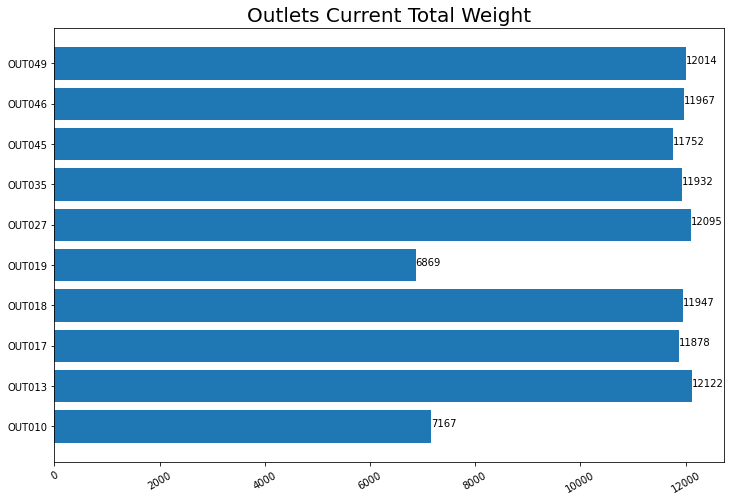

In [86]:
outlet_weights = df.groupby(['Outlet_Identifier'])['Item_Weight'].sum()
#outlet_weights
plt.figure(figsize = (12, 8));
plt.title('outlets current total weight'.title(), fontsize=20)
plt.barh(outlet_weights.index, outlet_weights.values);
plt.xticks(rotation = 30);
for index, value in enumerate(outlet_weights.values):
    plt.text(value, index, str(math.ceil(value)))


Visualize the fat Content per each outlet

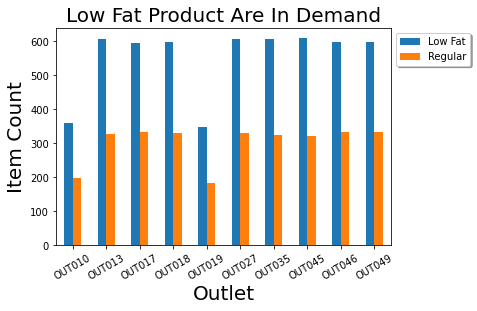

In [28]:
df.groupby(['Outlet_Identifier','Item_Fat_Content'])['Item_Fat_Content'].count().unstack().plot(kind='bar')

plt.title('low fat product are in demand'.title(), fontsize=20)
plt.xticks(rotation = 30);
plt.xlabel('Outlet', fontsize=20)
plt.ylabel('Item Count', fontsize=20)
plt.legend(bbox_to_anchor=(1, 1), shadow = True);

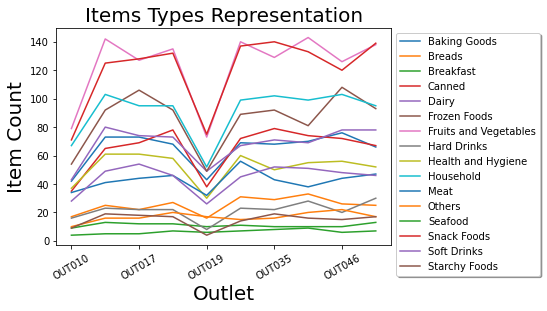

In [58]:
total_type = df.groupby(['Outlet_Identifier','Item_Type'])['Item_Type'].count().unstack()
total_type.plot()

plt.title('items types representation'.title(), fontsize=20)
plt.xticks(rotation = 30);
plt.xlabel('Outlet', fontsize=20)
plt.ylabel('Item Count', fontsize=20)
plt.legend(bbox_to_anchor=(1, 1), shadow = True);
#plt.figure(figsize = (12, 8));

Depending on the audience, there are many other way to visualize the statistics of this data set.

I will start with displaying the top 5 sale items in each outlet

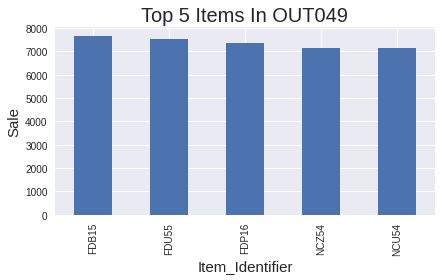

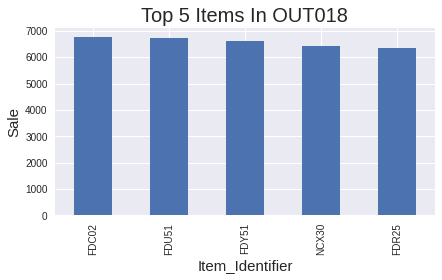

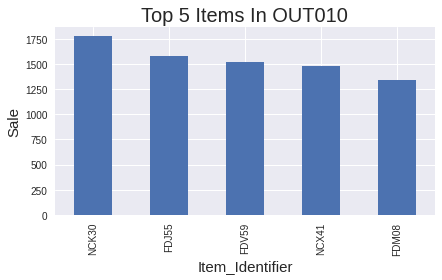

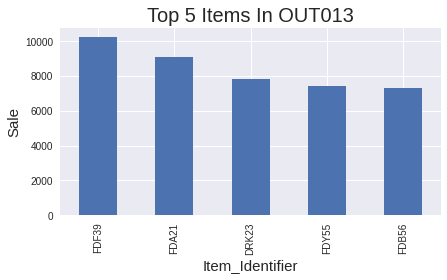

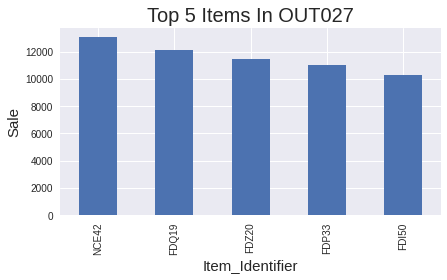

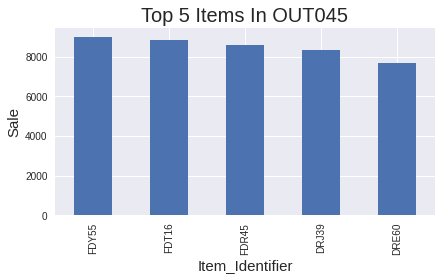

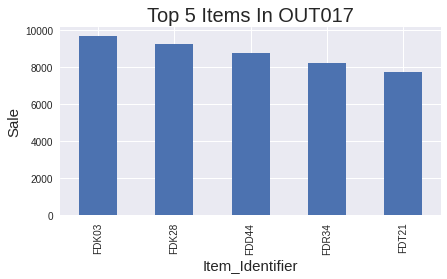

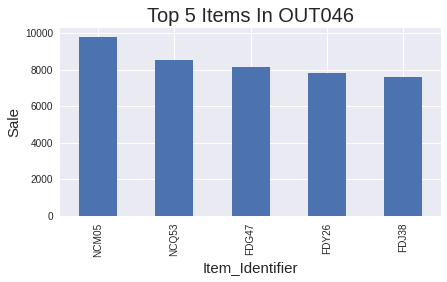

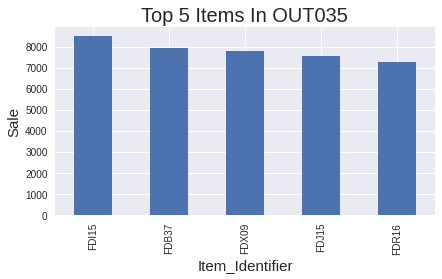

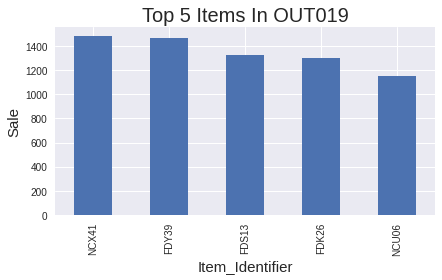

In [188]:
outlets = df['Outlet_Identifier'].unique()
for i, v in enumerate(outlets):  
  plt.figure(figsize = (15, 20))
  plt.subplot(5, 2, i+1)
  plt.title('top 5 items in '.title() + v, fontsize=20)
  plt.xticks(rotation = 30)
  plt.xlabel('Items', fontsize=15)
  plt.ylabel('Sale', fontsize=15)
  g = df.loc[df['Outlet_Identifier']== v].groupby(['Item_Identifier'])['Item_Outlet_Sales'].sum().sort_values(ascending=False).head(5)
  g.plot(kind='bar')  
  

I am also assuming everyone would want to see the total sales for each outlet

Text(0, 0.5, 'Sale')

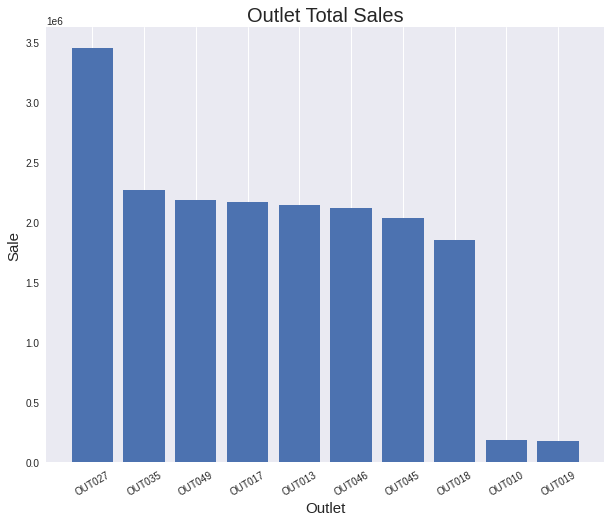

In [189]:
total_sales = df.groupby(['Outlet_Identifier'])['Item_Outlet_Sales'].sum().sort_values(ascending=False)
plt.figure(figsize = (10, 8))
#ploting = total_sales.plot(kind='bar')
plt.bar(total_sales.index, total_sales.values);
plt.title('outlet total sales'.title(), fontsize=20)
plt.xticks(rotation = 30)
plt.grid(axis='y')

plt.xlabel('Outlet', fontsize=15)
plt.ylabel('Sale', fontsize=15)

Histograms to view the distributions of various features in your dataset.

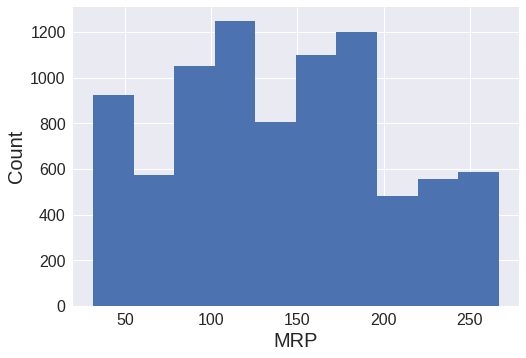

In [190]:
#It would be essential in sales predictions to get a histogram of the item MRP
plt.style.use('seaborn')
df['Item_MRP'].hist();
plt.xlabel('MRP', fontsize = 20);
plt.ylabel('Count', fontsize = 20);
plt.xticks(fontsize = 16);
plt.yticks(fontsize = 16);
#notice the high variation on the 100

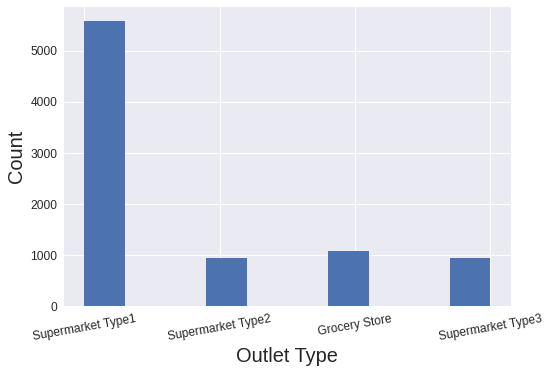

In [191]:
# I am interested in the outlet types to predict their sales
plt.style.use('seaborn')
df['Outlet_Type'].hist();
plt.xlabel('Outlet Type', fontsize = 20);
plt.ylabel('Count', fontsize = 20);
plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);
plt.xticks(rotation = 10);
#the majority are in The Supermarket Type 1, the rest are around the same

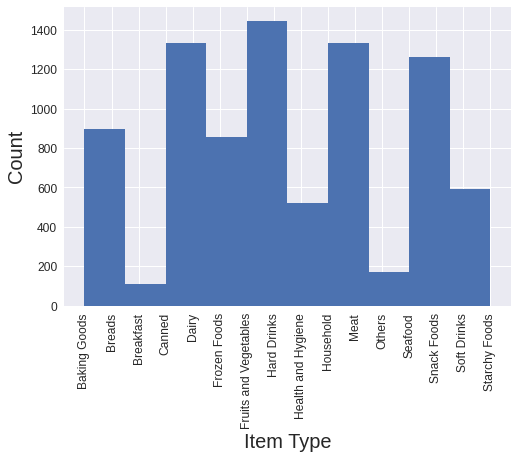

In [192]:
#interested now in sorting the items per types and hist to visualize
df_type_sorted = df.sort_values('Item_Type')
plt.style.use('seaborn')
df_type_sorted['Item_Type'].hist();
plt.xlabel('Item Type', fontsize = 20);
plt.ylabel('Count', fontsize = 20);
plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);
plt.xticks(rotation = 90);
#Fruit and Vegetables :)

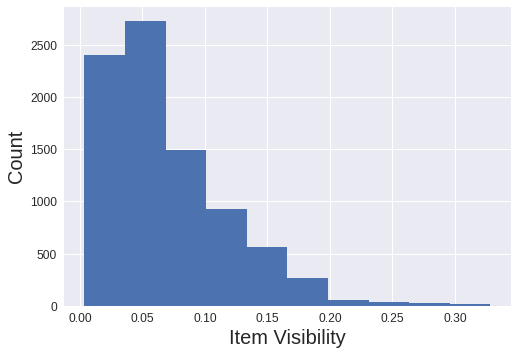

In [87]:
# I am pretty sure the item visibility also plays a role in sales
df_type_sorted = df.sort_values('Item_Type')
plt.style.use('seaborn')
df_type_sorted['Item_Visibility'].hist();
plt.xlabel('Item Visibility', fontsize = 20);
plt.ylabel('Count', fontsize = 20);
plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);

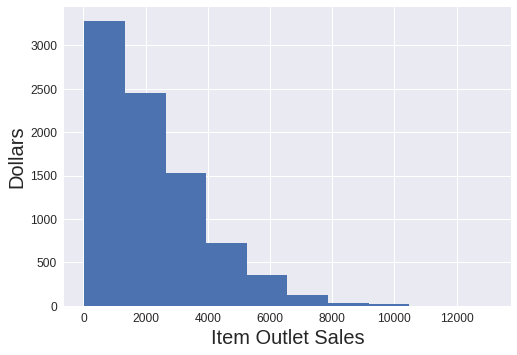

In [88]:
df_type_sorted = df.sort_values('Item_Type')
plt.style.use('seaborn')
df_type_sorted['Item_Outlet_Sales'].hist();
plt.xlabel('Item Outlet Sales', fontsize = 20);
plt.ylabel('Dollars', fontsize = 20);
plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);

**Boxplots to view statistical summaries of various features in your dataset.**
Also identify outliers

In [195]:
outlet_item_sales = df.reset_index().groupby(['Outlet_Identifier'])['Item_Outlet_Sales'].apply(list)
outlet_item_sales = outlet_item_sales.reset_index()
outlet_item_sales

,Outlet_Identifier,Item_Outlet_Sales
0,OUT010,"[732.38, 178.4344, 163.7868, 358.2004, 184.426..."
1,OUT013,"[994.7052, 343.5528, 1977.4260000000002, 3775...."
2,OUT017,"[4710.535, 838.908, 3121.2704, 4815.0656, 2285..."
3,OUT018,"[443.4228, 556.6088, 1621.8888, 2741.7644, 306..."
4,OUT019,"[214.3876, 125.8362, 780.3176, 892.172, 147.80..."
5,OUT027,"[4022.7636, 2303.6679999999997, 4064.0432, 279..."
6,OUT035,"[2748.4224, 1587.2672, 1065.28, 4865.6664, 271..."
7,OUT045,"[1076.5986, 2174.5028, 2428.8384, 5815.0972, 2..."
8,OUT046,"[2187.153, 2145.2076, 1547.3192, 4078.025, 208..."
9,OUT049,"[3735.138, 2097.27, 1516.0266, 1589.2646, 718...."


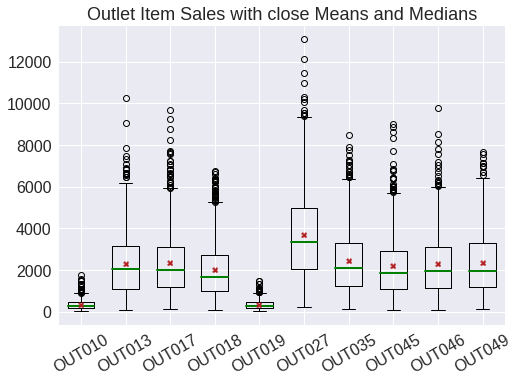

In [196]:
plt.style.use('seaborn')
indexList = []
for index, sales in enumerate(outlet_item_sales['Item_Outlet_Sales'].values):
  plt.boxplot(outlet_item_sales['Item_Outlet_Sales'].values[index],
              positions = [index],
              widths = .6,
              medianprops = dict(linestyle='-', linewidth=2, color='green'),
              showmeans = True,
              meanprops =dict(marker='X', markeredgecolor='black',
              markerfacecolor='firebrick'))
  indexList.append(index)
plt.xticks(indexList,outlet_item_sales['Outlet_Identifier'].values, fontsize = 16, rotation = 30)
plt.yticks(fontsize = 16)
plt.title('Outlet Item Sales with close Means and Medians', fontsize = 18);
#notice the outliers...

In [197]:
item_type_weight = df.reset_index().groupby(['Item_Type'])['Item_Weight'].apply(list)
item_type_weight = item_type_weight.reset_index()
item_type_weight

,Item_Type,Item_Weight
0,Baking Goods,"[10.395, 8.315, 15.5, 15.85, 15.85, 13.35, 12...."
1,Breads,"[17.85, 9.1, 12.6, 12.6, 17.85, 17.85, 9.6, 13..."
2,Breakfast,"[9.0, 9.0, 20.2, 18.6, 8.895, 10.695, 21.1, 7...."
3,Canned,"[14.5, 21.35, 12.15, 10.0, 9.895, 5.94, 7.855,..."
4,Dairy,"[9.3, 18.5, 13.35, 5.925, 19.25, 13.35, 6.42, ..."
5,Frozen Foods,"[16.2, 19.2, 13.85, 10.195, 15.5, 8.39, 19.0, ..."
6,Fruits and Vegetables,"[19.2, 11.8, 15.1, 16.35, 20.2, 10.895, 10.0, ..."
7,Hard Drinks,"[8.26, 11.65, 8.365, 8.88, 9.3, 15.75, 9.3, 12..."
8,Health and Hygiene,"[11.8, 18.6, 10.0, 19.6, 7.39, 8.645, 9.8, 12...."
9,Household,"[8.93, 14.6, 13.0, 12.15, 9.195, 7.825, 18.85,..."


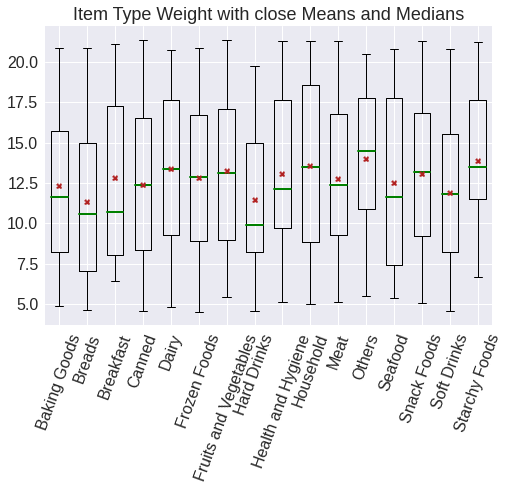

In [198]:
plt.style.use('seaborn')
indexList = []
for index, sales in enumerate(item_type_weight['Item_Weight'].values):
  plt.boxplot(item_type_weight['Item_Weight'].values[index],
              positions = [index],
              widths = .6,
              medianprops = dict(linestyle='-', linewidth=2, color='green'),
              showmeans = True,
              meanprops =dict(marker='X', markeredgecolor='black',
              markerfacecolor='firebrick'))
  indexList.append(index)
plt.xticks(indexList,item_type_weight['Item_Type'].values, fontsize = 16, rotation = 70)
plt.yticks(fontsize = 16)
plt.title('Item Type Weight with close Means and Medians', fontsize = 18);
#notice the outliers...

**Heatmaps** of the correlation between features after cleaning

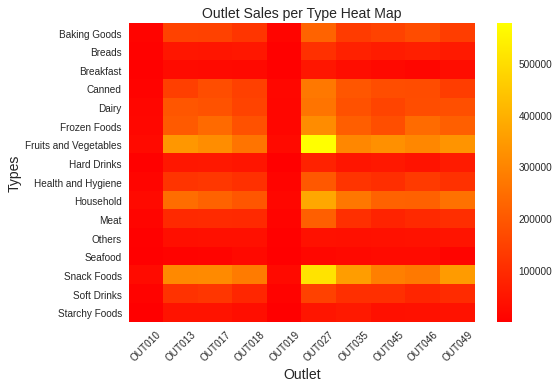

In [199]:
sales_per_outlet = df.groupby(['Outlet_Identifier', 'Item_Type'])[['Item_Outlet_Sales']].sum()
#sales_per_outlet
heatmap_data = pd.pivot_table(sales_per_outlet, values='Item_Outlet_Sales', index=['Item_Type'], columns='Outlet_Identifier')

sns.heatmap(heatmap_data, cmap='autumn');
plt.xlabel("Outlet", size=14)
plt.ylabel("Types", size=14)
plt.title("Outlet Sales per Type Heat Map", size=14)
plt.xticks(rotation = 45);
plt.tight_layout()

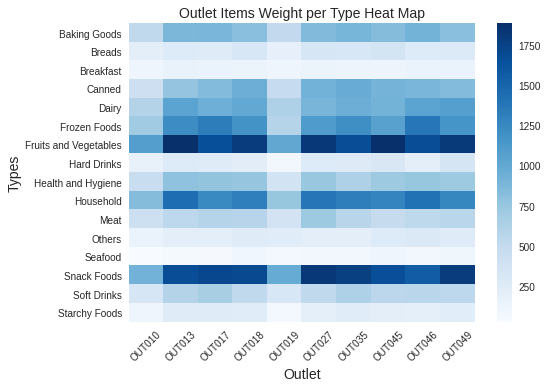

In [200]:
weight_per_outlet = df.groupby(['Outlet_Identifier', 'Item_Type'])[['Item_Weight']].sum()

heatmap_data_wieght = pd.pivot_table(weight_per_outlet, values='Item_Weight', index=['Item_Type'], columns='Outlet_Identifier')

sns.heatmap(heatmap_data_wieght, cmap='Blues');
plt.xlabel("Outlet", size=14)
plt.ylabel("Types", size=14)
plt.title("Outlet Items Weight per Type Heat Map", size=14)
plt.xticks(rotation = 45);
plt.tight_layout()

#**Final columns preparation**


**Dealing with Categorical Variables**

In [201]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

I am going to use some of the methods in: 
*   https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/
*   https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63

to deal with the ordinal and nominal columns in the dataframe


In [89]:
# I found a cool way to get the categorical columns here:
# https://www.datacamp.com/community/tutorials/categorical-data
# I can use this way to filter out those columns when creating the 
#feature matrix :)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [90]:
#Taking another peek at df with those columns
df.loc[:,cat_cols].head()

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,Small,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,High,Tier 3,Supermarket Type1


Dealing with the ordinal categorical variables by assigning them to a dictionary of order starting at 0.

I believe the only Ordinal variable here is the outlet size. I would have to understand the meaning of location type and consider if it is oridnal tier but for now, I will assume it is a nominal category.

In [91]:
dict_outlet_size = {'Small': 0, 'Medium': 1, 'High': 2}
df['Outlet_Size'] = df['Outlet_Size'].map(dict_outlet_size)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,1,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,1,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,1,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,OUT010,1998,0,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.066132,Household,53.8614,OUT013,1987,2,Tier 3,Supermarket Type1,994.7052


Pandas get dummies the nominal categories. Execluding the Item_Identifier.

In [92]:
df_dummy = pd.get_dummies(df, columns=['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Location_Type', 'Outlet_Type'], drop_first=True)
df_dummy.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Outlet_Sales,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,FDA15,9.30,0.016047,249.8092,1999,1,3735.1380,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,DRC01,5.92,0.019278,48.2692,2009,1,443.4228,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
2,FDN15,17.50,0.016760,141.6180,1999,1,2097.2700,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,FDX07,19.20,0.066132,182.0950,1998,0,732.3800,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,NCD19,8.93,0.066132,53.8614,1987,2,994.7052,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0


Finally before creating the model, I want to take care of the Item_Identifier column as it looks like get dummies might create hundreds of columns for it.

I did however notice they all start with unique two letter identifier. Going to investigate that.

Found this method to see if the items start with FD, NC, DR:
https://stackoverflow.com/questions/48328110/how-to-select-column-values-which-start-from-specific-patterns-in-pandas-data-fr/48328169

In [206]:
fd = df_dummy.loc[df_dummy.Item_Identifier.str.startswith('FD'), 'Item_Identifier'].count()
nc = df_dummy.loc[df_dummy.Item_Identifier.str.startswith('NC'), 'Item_Identifier'].count()
dr = df_dummy.loc[df_dummy.Item_Identifier.str.startswith('DR'), 'Item_Identifier'].count()
print("FD: {}, \nNC: {}, \nDR: {},".format(fd, nc, dr), "\nTotal: {}".format(fd+nc+dr), ", which matches the total of records: {}".format(df_dummy.Item_Identifier.count()))

FD: 6125, 
NC: 1599, 
DR: 799, 
Total: 8523 , which matches the total of records: 8523


Adding a new column for Item_Identifier_Type with 3 values (FD, NC, DR)

In [93]:
# using this method to add the new column:
# https://www.geeksforgeeks.org/create-a-new-column-in-pandas-dataframe-based-on-the-existing-columns/
df_dummy['Item_Identifier_Group']=df_dummy.apply(lambda row: row.Item_Identifier[0:2], axis=1)
df_dummy.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Outlet_Sales,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Identifier_Group
0,FDA15,9.30,0.016047,249.8092,1999,1,3735.1380,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,FD
1,DRC01,5.92,0.019278,48.2692,2009,1,443.4228,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,DR
2,FDN15,17.50,0.016760,141.6180,1999,1,2097.2700,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,FD
3,FDX07,19.20,0.066132,182.0950,1998,0,732.3800,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,FD
4,NCD19,8.93,0.066132,53.8614,1987,2,994.7052,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,NC


Time to drop the original item identifier column and get dummies or one hot encode the new created columns with 3 item identifier types.

In [106]:
df_dummy = pd.get_dummies(df_dummy, columns=['Item_Identifier_Group'])
df_dummy.drop(columns=['Item_Identifier'],inplace=True)
#Make sure the data frame is ready for machine learning
df_dummy.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Outlet_Sales,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Identifier_Group_DR,Item_Identifier_Group_FD,Item_Identifier_Group_NC
0,9.30,0.016047,249.8092,1999,1,3735.1380,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
1,5.92,0.019278,48.2692,2009,1,443.4228,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0
2,17.50,0.016760,141.6180,1999,1,2097.2700,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
3,19.20,0.066132,182.0950,1998,0,732.3800,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,8.93,0.066132,53.8614,1987,2,994.7052,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1


In [107]:
df_dummy.columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Item_Outlet_Sales',
       'Item_Fat_Content_Regular', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supe

In [108]:
df_dummy.shape

(8523, 39)

In [96]:
#Creating the feature matrix and target vector
X = df_dummy.drop(columns='Item_Outlet_Sales')
y = df_dummy.loc[:, 'Item_Outlet_Sales'].values
print (f'X_Shape: {X.shape}\ny_shape: {y.shape}')

X_Shape: (8523, 37)
y_shape: (8523,)


In [97]:
# getting a train and test datasets to fit and test the machine learning models
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#**Linear Regression to predict sales**

In [109]:
#Creating the feature matrix and vector
X = df_dummy.drop(columns='Item_Outlet_Sales')
y = df_dummy.loc[:, 'Item_Outlet_Sales'].values
print (f'X_Shape: {X.shape}\ny_shape: {y.shape}')

X_Shape: (8523, 38)
y_shape: (8523,)


In [110]:
# getting a train and test datasets to fit and test the machine learning models
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [111]:
#instantiate
lr = LinearRegression(fit_intercept=True)

In [112]:
#Train the model
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [113]:
#prediction
lr_y_pred = lr.predict(X_test)

In [114]:
#Measure score
lr_score_test = lr.score(X_test, y_test)
lr_score_train = lr.score(X_train, y_train)
print(f'Linear Regression Score Train: {lr_score_train}\nLinear Regression Score Test: {lr_score_test}')

Linear Regression Score Train: 0.5636762127462246
Linear Regression Score Test: 0.5615774082021592


In [115]:
#MSE & RMSE
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_rmse = mean_squared_error(y_test, lr_y_pred, squared=False)
print(f'MSE: {lr_mse}, RMSE: {lr_rmse}')

MSE: 1269642.466643601, RMSE: 1126.7841260168698


In [116]:
#Measure r squared
lr_r_squared = r2_score(y_test, lr_y_pred)
lr_r_squared

0.5615774082021592

In [117]:
#mae
lr_mae = mean_absolute_error(y_test, lr_y_pred)
lr_mae

840.0354082298451

Interested in the coef of the columns to see what factors in the sales price to go up

In [389]:
lr.coef_

array([ 2.97396457e+00, -4.04840925e+02,  1.56542130e+01,  5.56725445e+00,
        8.38509794e+02,  2.40778378e+01,  2.08038210e+01, -6.72537744e+00,
        2.38885795e+01, -9.61579032e+01, -3.71356608e+01,  3.12067281e+01,
        4.99069291e+01,  2.82404829e+01, -1.03350588e+01, -8.36576660e+00,
       -2.74224606e+01,  2.91316471e+02,  2.98706220e+00, -1.10775299e+00,
       -6.06391954e+00, -3.61946302e+02,  1.85569377e+02,  3.73308772e+02,
       -4.83751794e+02,  1.30985259e+03,  2.64775741e+02,  4.74731588e+01,
        6.70840663e+02, -1.20758968e+02,  4.97818277e+02, -5.64148177e+02,
        6.85953669e+02,  3.73308772e+02,  1.30985259e+03, -3.90316199e+01,
        4.85486564e+01, -9.51703647e+00])

Feature: 0, Score: 2.97396
Feature: 1, Score: -404.84092
Feature: 2, Score: 15.65421
Feature: 3, Score: 5.56725
Feature: 4, Score: 838.50979
Feature: 5, Score: 24.07784
Feature: 6, Score: 20.80382
Feature: 7, Score: -6.72538
Feature: 8, Score: 23.88858
Feature: 9, Score: -96.15790
Feature: 10, Score: -37.13566
Feature: 11, Score: 31.20673
Feature: 12, Score: 49.90693
Feature: 13, Score: 28.24048
Feature: 14, Score: -10.33506
Feature: 15, Score: -8.36577
Feature: 16, Score: -27.42246
Feature: 17, Score: 291.31647
Feature: 18, Score: 2.98706
Feature: 19, Score: -1.10775
Feature: 20, Score: -6.06392
Feature: 21, Score: -361.94630
Feature: 22, Score: 185.56938
Feature: 23, Score: 373.30877
Feature: 24, Score: -483.75179
Feature: 25, Score: 1309.85259
Feature: 26, Score: 264.77574
Feature: 27, Score: 47.47316
Feature: 28, Score: 670.84066
Feature: 29, Score: -120.75897
Feature: 30, Score: 497.81828
Feature: 31, Score: -564.14818
Feature: 32, Score: 685.95367
Feature: 33, Score: 373.30877
Fe

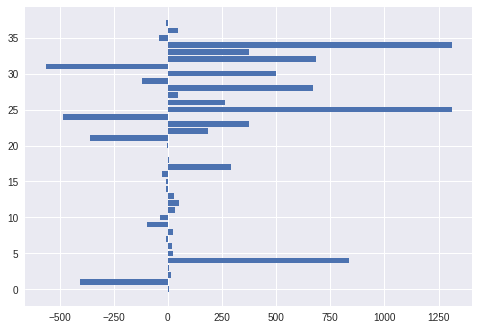

In [390]:
# get importance
importance = lr.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.barh([x for x in range(len(importance))], importance)
pyplot.show()

#**Bagged Tree**

In [118]:
#Creating the feature matrix and vector
X = df_dummy.drop(columns='Item_Outlet_Sales')
y = df_dummy.loc[:, 'Item_Outlet_Sales'].values
print (f'X_Shape: {X.shape}\ny_shape: {y.shape}')

X_Shape: (8523, 38)
y_shape: (8523,)


In [119]:
# getting a train and test datasets to fit and test the machine learning models
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [120]:
# Bagged trees regressor
bt = BaggingRegressor()
bt.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [121]:
#Measure score
bt_score_test = bt.score(X_test, y_test)
bt_score_train = bt.score(X_train, y_train)
print(f'Bagged Tree Score Train: {lr_score_train}\nBagged Tree Score Test: {lr_score_test}')

Bagged Tree Score Train: 0.5636762127462246
Bagged Tree Score Test: 0.5615774082021592


In [122]:
#prediction
bt_y_pred = bt.predict(X_test)

In [123]:
#MSE & RMSE
bt_mse = mean_squared_error(y_test, bt_y_pred)
bt_rmse = mean_squared_error(y_test, bt_y_pred, squared=False)
print(f'MSE: {lr_mse}, RMSE: {lr_rmse}')

MSE: 1269642.466643601, RMSE: 1126.7841260168698


In [124]:
#Measure r squared
bt_r_squared = r2_score(y_test, bt_y_pred)
bt_r_squared

0.5071764907221881

In [125]:
#mae
bt_mae = mean_absolute_error(y_test, bt_y_pred)
bt_mae

830.8463211356171

# **Random Forest**

In [126]:
#Creating the feature matrix and vector
X = df_dummy.drop(columns='Item_Outlet_Sales')
y = df_dummy.loc[:, 'Item_Outlet_Sales'].values
print (f'X_Shape: {X.shape}\ny_shape: {y.shape}')

X_Shape: (8523, 38)
y_shape: (8523,)


In [127]:
# getting a train and test datasets to fit and test the machine learning models
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [128]:
# Random Forest regressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [129]:
#Measure score
rf_score_test = rf.score(X_test, y_test)
rf_score_train = rf.score(X_train, y_train)
print(f'Bagged Tree Score Train: {rf_score_train}\nBagged Tree Score Test: {rf_score_test}')

Bagged Tree Score Train: 0.9384201812687573
Bagged Tree Score Test: 0.5469275440006702


In [130]:
# predict
rf_y_pred = rf.predict(X_test)

In [131]:
#MSE & RMSE
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = mean_squared_error(y_test, rf_y_pred, squared=False)
print(f'MSE: {rf_mse}, RMSE: {rf_rmse}')

MSE: 1312067.4923351351, RMSE: 1145.4551463654677


In [132]:
#Measure r squared
rf_r_squared = r2_score(y_test, rf_y_pred)
rf_r_squared

0.5469275440006702

In [133]:
#mae
rf_mae = mean_absolute_error(y_test, rf_y_pred)
rf_mae

796.7834213786955

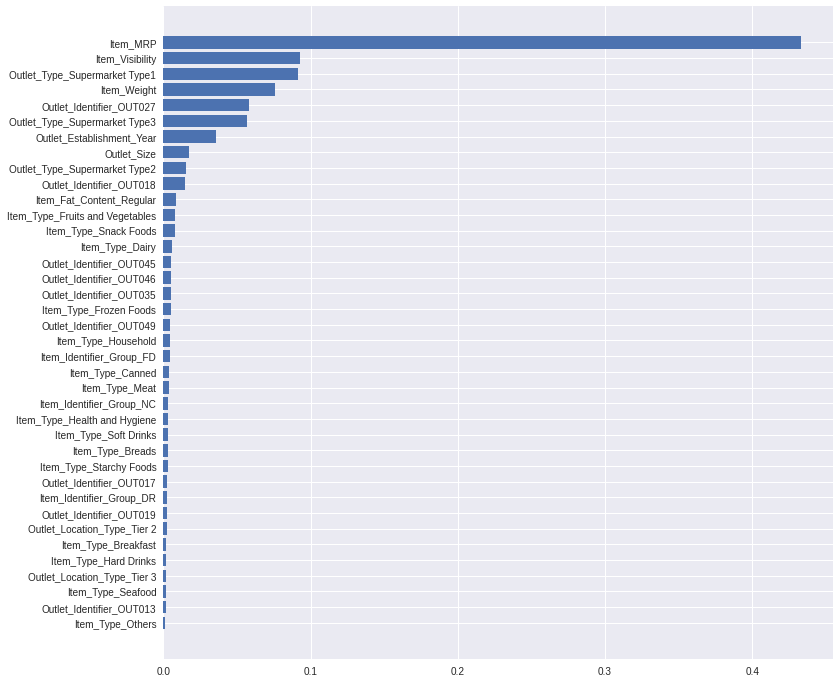

In [134]:
# save feature importance & feature names as df so I can sort them
rf_features = pd.DataFrame({'feature': X_train.columns, 'feature_importance': rf.feature_importances_})
rf_features.sort_values(by = 'feature_importance', inplace = True)

plt.figure(figsize = (12, 12))
plt.barh(rf_features['feature'], rf_features['feature_importance']);

#**KNN to predict sales**

In [135]:
# Standardize data
scaler = StandardScaler()
# Fit on X (assuming your features matrix is a NumPy array)
# Always fit on the training data
scaler.fit(X_train)
# Transform X_train and X_test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [136]:
# KNN - Regressor
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [137]:
#Measure score
knn_score_test = knn.score(X_test, y_test)
knn_score_train = knn.score(X_train, y_train)
print(f'KNN Score Train: {knn_score_train}\nKNN Score Test: {knn_score_test}')

KNN Score Train: 0.6514812919276203
KNN Score Test: 0.45062416472232064


In [138]:
# predict
knn_y_pred = knn.predict(X_test)

In [139]:
#MSE & RMSE
knn_mse = mean_squared_error(y_test, knn_y_pred)
knn_rmse = mean_squared_error(y_test, knn_y_pred, squared=False)
print(f'MSE: {knn_mse}, RMSE: {knn_rmse}')

MSE: 1590955.6297180231, RMSE: 1261.3308962036976


In [140]:
#Measure r squared
knn_r_squared = r2_score(y_test, knn_y_pred)
knn_r_squared

0.4506241647223206

In [141]:
#mae
knn_mae = mean_absolute_error(y_test, knn_y_pred)
knn_mae

909.060262261849

Researched to find the feature importance in the matrix:
https://machinelearningmastery.com/calculate-feature-importance-with-python/

Feature: 0, Score: -14607.55565
Feature: 1, Score: 434.42042
Feature: 2, Score: 91787.31563
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: -26781.08820
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 13846.47322
Feature: 9, Score: 21226.11676
Feature: 10, Score: 8961.80177
Feature: 11, Score: -11348.08800
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: -41343.71978
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: -9614.47557
Feature: 19, Score: -821.41798
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, S

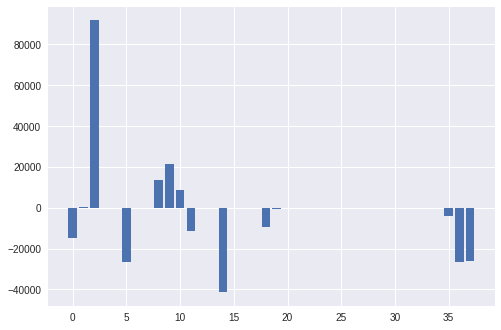

In [398]:
# perform permutation importance
results = permutation_importance(knn_reg, X, y, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# **Tunning Bagged Trees and Random Forest**

We could also try and tune other parameters in this model. Such as: n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_features, max_leaf_nodes, min_impurity_decrease, min_impurity_split, bootstrap, oob_score, ccp_alpha, max_samples.

In this section I will tune the n_estimator to find what number would return the best results, as the default is 100.

In [142]:
estimator_range = [1] + list(range(10, 310, 10))
estimator_range

[1,
 10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300]

In [143]:
# List to store the average accuracies for each value of n_estimators:
ran_scores = []
bag_scores = []
# Use train test split with each value of n_estimators (Warning: Slow!).
for estimator in estimator_range:
    ran_reg_tuning = RandomForestRegressor(n_estimators=estimator,
                                 random_state=4,
                                 bootstrap=True).fit(X_train, y_train)
    ran_scores.append(ran_reg_tuning.score(X_test, y_test))

    bag_reg_tuning = BaggingRegressor(n_estimators=estimator,
                                 random_state=4,
                                 bootstrap=True).fit(X_train, y_train)
    bag_scores.append(bag_reg_tuning.score(X_test, y_test))

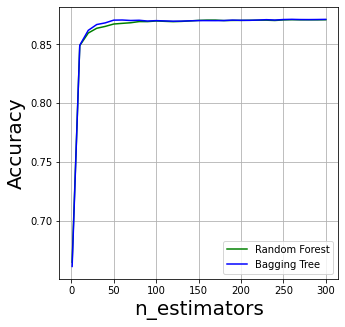

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5));
axes.plot(estimator_range, ran_scores, c='green', label='Random Forest');
axes.plot(estimator_range, bag_scores, c='blue', label='Bagging Tree');
axes.set_xlabel('n_estimators', fontsize =20);
axes.set_ylabel('Accuracy', fontsize = 20);
axes.grid();
axes.legend();

Based on the above graph, it looks like the default n_estimator of 100 was good enough, no need to tune in there.

# **Model Evaluation**

I am going to evaluate the regression models used based on:

*   R^2
*   MAE
*   MSE
*   RMSE

By creating a dataframe to hold the values and try to spot the best model that should be used for the sales predictions dateset.


In [364]:
eval_df = pd.DataFrame(columns=['model', 'r_squared', 'mae', 'mse', 'rmse', 'score_train', 'score_test'])
#Linear Regression
lr_row = {'model':'Linear Regression', 'r_squared':lr_r_squared, 'mae':lr_mae, 'mse':lr_mse, 
                'rmse':lr_rmse, 'score_train':lr_score_train, 'score_test':lr_score_test }
eval_df = eval_df.append(lr_row, ignore_index=True)
#Bagged Tree
bt_row = {'model':'Bagged Tree', 'r_squared':bt_r_squared, 'mae':bt_mae, 'mse':bt_mse, 
                'rmse':bt_rmse, 'score_train':bt_score_train, 'score_test':bt_score_test }
eval_df = eval_df.append(bt_row, ignore_index=True)
# Random Forest
rf_row = {'model':'Random Forest', 'r_squared':rf_r_squared, 'mae':rf_mae, 'mse':rf_mse, 
                'rmse':rf_rmse, 'score_train':rf_score_train, 'score_test':rf_score_test }
eval_df = eval_df.append(rf_row, ignore_index=True)
#KNN
knn_row = {'model':'KNN', 'r_squared':knn_r_squared, 'mae':knn_mae, 'mse':knn_mse, 
                'rmse':knn_rmse, 'score_train':knn_score_train, 'score_test':knn_score_test }
eval_df = eval_df.append(knn_row, ignore_index=True)
eval_df

,model,r_squared,mae,mse,rmse,score_train,score_test
0,Linear Regression,0.561424,840.239080,1.270087e+06,1126.981464,0.563763,0.561424
1,Bagged Tree,0.500668,831.780566,1.446032e+06,1202.510543,0.919861,0.500668
2,Random Forest,0.549032,794.303915,1.305973e+06,1142.791892,0.938623,0.549032
3,KNN,0.447473,911.850998,1.600081e+06,1264.943185,0.651281,0.447473


By looking at the above values, I would pick linear regression as the supervised machine learning model for sales predictions on this dataset. Based on the high score on the test dataset and how close that is to the train score, which means, it wasn't overfit on the train.. Also the r_squared is closer to 1 than all others. Low RMSE and average MAE compared to the other models also strengthens my choise.